# General Purpose Defect Inspection
## Experiment with different models using a dataset of M&Ms to detect various defects. 

In [1]:
import keras
import keras_metrics as km
from keras.models import Sequential,load_model
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2

Using TensorFlow backend.


### Read the labels, set the directory.

In [2]:
img_dir = 'newmm/crop_mm'
df=pd.read_csv('newmm/crop_mm_relabel.csv')
columns=df.columns.tolist()[1:] #columns are the labels, or type of defects.

In [3]:
# What the labels look like, 1 --> defect is present.
# partialm means the letter "M" isn't printed in whole, or partially missing.
# offcenterm means the letter "M" isn't on the center of button.
# bad shape means the button isn't round, has a weird shape.
# bad surface means there are surface blemish, e.g. chips, etc.
df.head()

,External ID,partialm,offcenterm,badshape,badsurface
0,IMG756.jpg,0,0,0,0
1,IMG20.jpg,0,0,1,1
2,IMG788.jpg,0,0,0,0
3,IMG52.jpg,0,0,1,1
4,IMG820.jpg,1,0,0,0


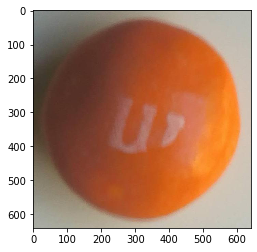

In [4]:
# Open an image and see what it looks like. 
# Notice a corner of the "M" letter is missing, otherwise it "looks" fine, thus labeled (1, 0, 0, 0).
img=mpimg.imread('newmm/crop_mm/IMG820.jpg')
plt.imshow(img)

### Create train, validation and test generators with 80-10-10 split, save last one for single image inference test

In [5]:
# Downsample the images to 160x160
image_size = 160
batch_size = 16

In [6]:
train_datagen=ImageDataGenerator(rescale=1./255,horizontal_flip=True,vertical_flip=True,rotation_range=180)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=train_datagen.flow_from_dataframe(
dataframe=df[:round(df.shape[0]*0.8)],
directory=img_dir,
x_col="External ID",
y_col=columns,
batch_size=batch_size,
seed=1,
shuffle=True,
class_mode="other",
target_size=(image_size,image_size))

Found 1069 validated image filenames.


In [7]:
valid_generator=test_datagen.flow_from_dataframe(
dataframe=df[round(df.shape[0]*0.8):round(df.shape[0]*0.9)],
directory=img_dir,
x_col="External ID",
y_col=columns,
batch_size=round(df.shape[0]*0.9)- round(df.shape[0]*0.8),
shuffle=False,
class_mode="other",
target_size=(image_size,image_size))

Found 133 validated image filenames.


In [8]:
test_generator=test_datagen.flow_from_dataframe(
dataframe=df[round(df.shape[0]*0.9):-1],
directory=img_dir,
x_col="External ID",
y_col=columns,
batch_size=df.shape[0] -1 - round(df.shape[0]*0.9) ,
shuffle=False,
class_mode="other",
target_size=(image_size,image_size))

Found 133 validated image filenames.


### Get step size per epoch

In [9]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

### Create log dir for tensorboard visualization

In [10]:
if not os.path.exists('my_log_dir/'):
    os.makedirs('my_log_dir/')

### Create custom metrics, precision and recall.

In [12]:
# Calculate precision for the first label.
precision = km.binary_precision(label=0)

# Calculate recall for the first label.
recall = km.binary_recall(label=0)

Instructions for updating:
Colocations handled automatically by placer.


## Build a CNN of a few conv blocks, train from scratch


### Create callbacks to optimize training

In [11]:
callbacks_list = [
keras.callbacks.EarlyStopping(
monitor='val_acc',
patience=30,
),
keras.callbacks.ModelCheckpoint(
filepath='mm_scratch.h5',
monitor='val_acc',
save_best_only=True,
),
keras.callbacks.ReduceLROnPlateau(
monitor='val_loss',
factor=0.5,
patience=30,
),
keras.callbacks.TensorBoard(
log_dir='my_log_dir',
histogram_freq=0, write_graph=True,
)
]

In [13]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(len(columns), activation='sigmoid'))
model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss="binary_crossentropy",metrics=["accuracy",precision,recall])

history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=300,
                    callbacks=callbacks_list,
)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/300
66/66 [==============================] - 12s 184ms/step - loss: 0.8449 - acc: 0.5471 - precision: 0.5988 - recall: 0.5328 - val_loss: 0.7523 - val_acc: 0.5132 - val_precision: 0.6951 - val_recall: 0.6706
Epoch 2/300
66/66 [==============================] - 11s 160ms/step - loss: 0.7293 - acc: 0.5899 - precision: 0.6473 - recall: 0.5598 - val_loss: 0.9615 - val_acc: 0.5376 - val_precision: 0.8000 - val_recall: 0.7059
Epoch 3/300
66/66 [==============================] - 11s 171ms/step - loss: 0.6879 - acc: 0.6020 - precision: 0.6451 - recall: 0.5986 - val_loss: 0.6474 - val_acc: 0.6015 - val_precision: 0.7162 - val_recall: 0.6235
Epoch 4/300
66/66 [==============================] - 11s 172ms/step - loss: 0.6543 - acc: 0.6339 - precision: 0.6913 - recall: 0.6096 - val_loss: 0.6423 - val_acc: 0.6410 - val_precision: 0

Epoch 36/300
66/66 [==============================] - 11s 172ms/step - loss: 0.4872 - acc: 0.7541 - precision: 0.7953 - recall: 0.7769 - val_loss: 0.4968 - val_acc: 0.7594 - val_precision: 0.7527 - val_recall: 0.8235
Epoch 37/300
66/66 [==============================] - 11s 172ms/step - loss: 0.4848 - acc: 0.7628 - precision: 0.7747 - recall: 0.7968 - val_loss: 0.4740 - val_acc: 0.7650 - val_precision: 0.7843 - val_recall: 0.9412
Epoch 38/300
66/66 [==============================] - 11s 172ms/step - loss: 0.4825 - acc: 0.7571 - precision: 0.7717 - recall: 0.8000 - val_loss: 0.4849 - val_acc: 0.7538 - val_precision: 0.8022 - val_recall: 0.8588
Epoch 39/300
66/66 [==============================] - 11s 172ms/step - loss: 0.4703 - acc: 0.7751 - precision: 0.7990 - recall: 0.8060 - val_loss: 0.5038 - val_acc: 0.7462 - val_precision: 0.8434 - val_recall: 0.8235
Epoch 40/300
66/66 [==============================] - 11s 174ms/step - loss: 0.4909 - acc: 0.7577 - precision: 0.7904 - recall: 0.78

Epoch 74/300
66/66 [==============================] - 11s 173ms/step - loss: 0.4582 - acc: 0.7708 - precision: 0.8010 - recall: 0.8263 - val_loss: 0.4328 - val_acc: 0.7932 - val_precision: 0.8667 - val_recall: 0.9176
Epoch 75/300
66/66 [==============================] - 11s 173ms/step - loss: 0.4510 - acc: 0.7799 - precision: 0.8356 - recall: 0.8442 - val_loss: 0.4815 - val_acc: 0.7744 - val_precision: 0.9125 - val_recall: 0.8588
Epoch 76/300
66/66 [==============================] - 12s 175ms/step - loss: 0.4558 - acc: 0.7803 - precision: 0.8084 - recall: 0.8394 - val_loss: 0.4687 - val_acc: 0.7876 - val_precision: 0.8780 - val_recall: 0.8471
Epoch 77/300
66/66 [==============================] - 11s 174ms/step - loss: 0.4514 - acc: 0.7814 - precision: 0.8191 - recall: 0.8149 - val_loss: 0.5113 - val_acc: 0.7594 - val_precision: 0.7383 - val_recall: 0.9294
Epoch 78/300
66/66 [==============================] - 11s 173ms/step - loss: 0.4364 - acc: 0.7862 - precision: 0.8228 - recall: 0.82

### No overfitting, learning curve is flatterning in the end

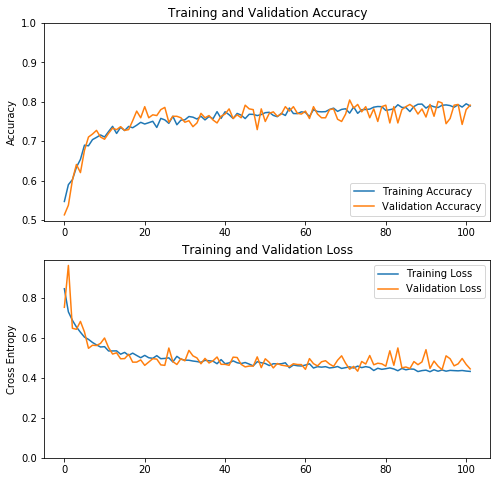

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [17]:
model.load_weights('mm_scratch.h5')

In [18]:
test_generator.reset()
test_loss, test_acc, test_pre, test_rec = model.evaluate_generator(test_generator, steps = STEP_SIZE_TEST)
print('test acc:', test_acc, 'test pre:', test_pre, 'test rec:', test_rec)

test acc: 0.8308270573616028 test pre: 0.867647057547578 test rec: 0.8309859143225551


## Transfer learning with pre-trained network

In [24]:
callbacks_list = [
keras.callbacks.EarlyStopping(
monitor='val_acc',
patience=30,
),
keras.callbacks.ModelCheckpoint(
filepath='mm_transfer.h5',
monitor='val_acc',
save_best_only=True,
),
keras.callbacks.ReduceLROnPlateau(
monitor='val_loss',
factor=0.5,
patience=30,
),
keras.callbacks.TensorBoard(
log_dir='my_log_dir',
histogram_freq=0, write_graph=True,
)
]

In [19]:
# Create the base model from the pre-trained model
base_model = keras.applications.InceptionV3(input_shape=(image_size, image_size, 3),
                                               include_top=False, 
                                               weights='imagenet')

base_model.trainable = False

model = keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(len(columns), activation='sigmoid')
])

# Calculate precision for the first label.
precision = km.binary_precision(label=0)

# Calculate recall for the first label.
recall = km.binary_recall(label=0)

model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy',precision,recall])

In [20]:
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=300,
                    callbacks=callbacks_list,
)

Epoch 1/300
66/66 [==============================] - 14s 205ms/step - loss: 0.6551 - acc: 0.6039 - precision: 0.5756 - recall: 0.6109 - val_loss: 0.6999 - val_acc: 0.6485 - val_precision: 0.6364 - val_recall: 0.9882
Epoch 2/300
66/66 [==============================] - 10s 149ms/step - loss: 0.6245 - acc: 0.6297 - precision: 0.5379 - recall: 0.6317 - val_loss: 0.6948 - val_acc: 0.6504 - val_precision: 0.6412 - val_recall: 0.9882
Epoch 3/300
66/66 [==============================] - 11s 172ms/step - loss: 0.6245 - acc: 0.6149 - precision: 0.5552 - recall: 0.6359 - val_loss: 0.7092 - val_acc: 0.6635 - val_precision: 0.6439 - val_recall: 1.0000
Epoch 4/300
66/66 [==============================] - 11s 171ms/step - loss: 0.6198 - acc: 0.6227 - precision: 0.5837 - recall: 0.6444 - val_loss: 0.7102 - val_acc: 0.6635 - val_precision: 0.6489 - val_recall: 1.0000
Epoch 5/300
66/66 [==============================] - 11s 173ms/step - loss: 0.6144 - acc: 0.6257 - precision: 0.5924 - recall: 0.7038 - 

Epoch 39/300
66/66 [==============================] - 11s 170ms/step - loss: 0.5638 - acc: 0.6845 - precision: 0.7053 - recall: 0.7785 - val_loss: 0.6791 - val_acc: 0.6992 - val_precision: 0.7255 - val_recall: 0.8706
Epoch 40/300
66/66 [==============================] - 11s 170ms/step - loss: 0.5639 - acc: 0.6913 - precision: 0.6814 - recall: 0.7760 - val_loss: 0.6731 - val_acc: 0.6805 - val_precision: 0.7320 - val_recall: 0.8353
Epoch 41/300
66/66 [==============================] - 11s 170ms/step - loss: 0.5592 - acc: 0.6933 - precision: 0.6826 - recall: 0.7808 - val_loss: 0.7189 - val_acc: 0.6880 - val_precision: 0.7340 - val_recall: 0.8118
Epoch 42/300
66/66 [==============================] - 11s 169ms/step - loss: 0.5654 - acc: 0.6931 - precision: 0.6747 - recall: 0.7347 - val_loss: 0.6988 - val_acc: 0.6880 - val_precision: 0.7419 - val_recall: 0.8118
Epoch 43/300
66/66 [==============================] - 11s 170ms/step - loss: 0.5757 - acc: 0.6797 - precision: 0.6875 - recall: 0.75

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [25]:
base_model.trainable = True
# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
# Calculate precision for the first label.
precision = km.binary_precision(label=0)

# Calculate recall for the first label.
recall = km.binary_recall(label=0)
    
model.compile(loss='binary_crossentropy',
              optimizer = keras.optimizers.RMSprop(lr=0.0001),
              metrics=['accuracy',precision,recall])

In [26]:
history_fine = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=300,
                    callbacks=callbacks_list,
)

Epoch 1/300
66/66 [==============================] - 16s 246ms/step - loss: 0.5573 - acc: 0.6982 - precision: 0.7295 - recall: 0.7672 - val_loss: 0.5491 - val_acc: 0.7180 - val_precision: 0.8090 - val_recall: 0.8471
Epoch 2/300
66/66 [==============================] - 10s 157ms/step - loss: 0.5279 - acc: 0.7217 - precision: 0.7569 - recall: 0.7814 - val_loss: 0.5103 - val_acc: 0.7481 - val_precision: 0.8472 - val_recall: 0.7176
Epoch 3/300
66/66 [==============================] - 12s 179ms/step - loss: 0.5108 - acc: 0.7401 - precision: 0.8123 - recall: 0.8056 - val_loss: 0.5078 - val_acc: 0.7613 - val_precision: 0.9041 - val_recall: 0.7765
Epoch 4/300
66/66 [==============================] - 12s 181ms/step - loss: 0.5009 - acc: 0.7422 - precision: 0.7710 - recall: 0.7780 - val_loss: 0.5804 - val_acc: 0.7387 - val_precision: 0.8387 - val_recall: 0.9176
Epoch 5/300
66/66 [==============================] - 12s 177ms/step - loss: 0.4868 - acc: 0.7542 - precision: 0.8168 - recall: 0.7950 - 

Epoch 39/300
66/66 [==============================] - 12s 178ms/step - loss: 0.2371 - acc: 0.9054 - precision: 0.9141 - recall: 0.9204 - val_loss: 0.5923 - val_acc: 0.8308 - val_precision: 0.9036 - val_recall: 0.8824
Epoch 40/300
66/66 [==============================] - 11s 162ms/step - loss: 0.2070 - acc: 0.9187 - precision: 0.9077 - recall: 0.9475 - val_loss: 0.5685 - val_acc: 0.8064 - val_precision: 0.9000 - val_recall: 0.8471
Epoch 41/300
66/66 [==============================] - 12s 177ms/step - loss: 0.1900 - acc: 0.9218 - precision: 0.9427 - recall: 0.9362 - val_loss: 0.5463 - val_acc: 0.8120 - val_precision: 0.8795 - val_recall: 0.8588
Epoch 42/300
66/66 [==============================] - 12s 179ms/step - loss: 0.1895 - acc: 0.9217 - precision: 0.9460 - recall: 0.9266 - val_loss: 0.5086 - val_acc: 0.8308 - val_precision: 0.8571 - val_recall: 0.9176
Epoch 43/300
66/66 [==============================] - 12s 179ms/step - loss: 0.1921 - acc: 0.9218 - precision: 0.9306 - recall: 0.93

In [27]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

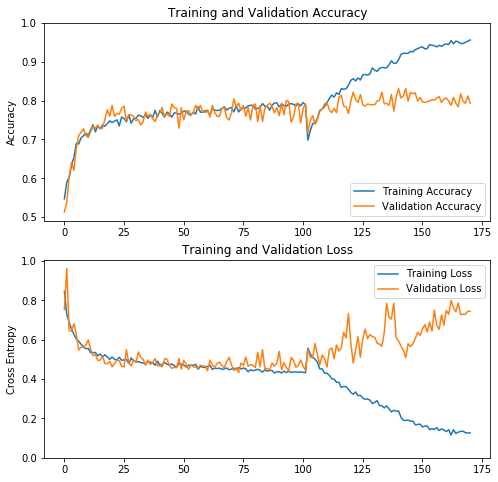

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [30]:
model.load_weights('mm_transfer.h5')

In [31]:
test_generator.reset()
test_loss, test_acc, test_pre, test_rec = model.evaluate_generator(test_generator, steps = STEP_SIZE_TEST)
print('test acc:', test_acc, 'test pre:', test_pre, 'test rec:', test_rec)

test acc: 0.8101503849029541 test pre: 0.8840579697332493 test rec: 0.8591549283673875


### Multiple Image inference with test dataset

In [32]:
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

1/1 [==============================] - 3s 3s/step


In [33]:
pred_bool = (pred >0.5)

In [34]:
predictions = pred_bool.astype(int)
results=pd.DataFrame(predictions, columns=columns)
results["External ID"]=test_generator.filenames
ordered_cols=["External ID"]+columns
results=results[ordered_cols]#To get the same column order
results.to_csv("mm_result.csv",index=False)

### Single Image inference

In [35]:
#load and downsample the image
img = cv2.imread('newmm/crop_mm/IMG721.jpg')
res = cv2.resize(img, dsize=(160, 160), interpolation=cv2.INTER_CUBIC)
test_img = np.expand_dims(res, 0)  
test_img = test_img/255.0
y = model.predict(test_img)

In [36]:
# predicated label [1,1,1,0]
y

array([[9.9955547e-01, 9.9890947e-01, 9.9913073e-01, 7.4505806e-07]],
      dtype=float32)

In [38]:
# Labels
df.iloc[-1]

External ID    IMG721.jpg
partialm                1
offcenterm              1
badshape                1
badsurface              1
Name: 1335, dtype: object

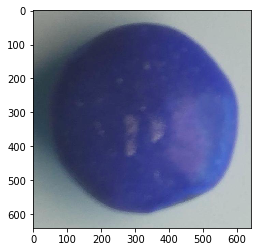

In [37]:
# it got the first three labels right, "M" letter is mostly missing, off centered and the shape is not round.
# but missed the bad surface label is labeled to 1 because of the hard to notice blemish on the bottom right
plt.imshow(img)

## In summery, the small CNN performed slightly better than transfer learning approach. 

### References:
Deep Learning with Python by François Chollet

Tutorial on Keras ImageDataGenerator with flow_from_dataframe by Vijayabhaskar J